# Imports + Basic Setup

In [1]:
# Imports & basic setup
import joblib
import os
import tempfile
import time
import warnings
import pickle
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU detected for TensorFlow.")

        # Test if XGBoost supports GPU
        try:
            _ = XGBRegressor(tree_method='gpu_hist')
            XGBOOST_TREE_METHOD = 'gpu_hist'
            print("XGBoost GPU mode enabled.")
        except:
            XGBOOST_TREE_METHOD = 'auto'
            print("XGBoost GPU not supported → using CPU mode.")

    except Exception as e:
        print("TensorFlow GPU init failed:", e)
        XGBOOST_TREE_METHOD = 'auto'
else:
    print("No GPU detected → CPU only.")
    XGBOOST_TREE_METHOD = 'auto'


No GPU detected → CPU only.


In [3]:
df=pd.read_csv("merged_energy_weather_data.csv")

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'], utc=True).dt.tz_convert("Europe/London")
df = df.sort_values('datetime').reset_index(drop=True)

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['year'] = df['datetime'].dt.year
#weekday 0=mon 6=sun
df['weekday'] = df['datetime'].dt.weekday
#weekend flag ie 1=sat/sun 0=mon-fri
df['is_weekend']=df['weekday'].apply(lambda x: 1 if x>=5 else 0)


# EDA

In [5]:
# 1. check missing values

In [6]:
df.isnull().sum()

SETTLEMENT_DATE              0
SETTLEMENT_PERIOD            0
ND                           0
TSD                          0
ENGLAND_WALES_DEMAND         0
EMBEDDED_WIND_GENERATION     0
EMBEDDED_WIND_CAPACITY       0
EMBEDDED_SOLAR_GENERATION    0
EMBEDDED_SOLAR_CAPACITY      0
NON_BM_STOR                  0
PUMP_STORAGE_PUMPING         0
SCOTTISH_TRANSFER            0
IFA_FLOW                     0
IFA2_FLOW                    0
BRITNED_FLOW                 0
MOYLE_FLOW                   0
EAST_WEST_FLOW               0
NEMO_FLOW                    0
NSL_FLOW                     0
ELECLINK_FLOW                0
VIKING_FLOW                  0
GREENLINK_FLOW               0
datetime                     0
time                         0
temperature_2m               0
relativehumidity_2m          0
pressure_msl                 0
wind_speed_10m               0
wind_direction_10m           0
precipitation                0
month                        0
day                          0
hour    

In [7]:
# 2. check duplicates

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
# Select only rows with duplicated datetime
duplicate_rows = df[df['datetime'].duplicated(keep=False)]

#Duplicate SETTLEMENT_DATE and datetime
duplicate_rows[['SETTLEMENT_DATE', 'datetime']]

,SETTLEMENT_DATE,datetime


In [10]:
# 3. check for impossible values eg negative energy demand or solar/wind generation
#negative value for demand
demand_cols=["ND","TSD","ENGLAND_WALES_DEMAND","EMBEDDED_WIND_GENERATION","EMBEDDED_WIND_CAPACITY","EMBEDDED_SOLAR_GENERATION","EMBEDDED_SOLAR_CAPACITY"]

neg_demand=df[(df[demand_cols]<0).any(axis=1)]
print(f"Negative:          {len(neg_demand)} rows")

Negative:          0 rows


In [11]:
#wind generation > capacity
exceed_wind=df[df["EMBEDDED_WIND_GENERATION"] > df["EMBEDDED_WIND_CAPACITY"]]

#solar generation> capacity
exceed_solar = df[df["EMBEDDED_SOLAR_GENERATION"] > df["EMBEDDED_SOLAR_CAPACITY"]]

print(f"Exceed Wind:          {len(exceed_wind)} rows")

print(f"Exceed Solar:          {len(exceed_solar)} rows")

Exceed Wind:          0 rows
Exceed Solar:          0 rows


In [12]:
# Temperature spikes
temp_spikes = df[(df['temperature_2m'] < -30) | (df['temperature_2m'] > 50)]

# Wind spikes
wind_speed_spikes = df[(df['wind_speed_10m'] < 0) | (df['wind_speed_10m'] > 60)]

#Huminity
humidity_invalid = df[(df['relativehumidity_2m'] < 0) | (df['relativehumidity_2m'] > 100)]

# pressure
pressure_invalid = df[(df['pressure_msl'] < 800) | (df['pressure_msl'] > 1100)]

# wind direction
wind_direction_invalid = df[(df['wind_direction_10m'] < 0) | (df['wind_direction_10m'] > 360)]

# precipitation
precipitation_negative = df[df['precipitation'] < 0]

print(f"Temperature unrealistic:          {len(temp_spikes)} rows")
print(f"Wind speed unrealistic:           {len(wind_speed_spikes)} rows")
print(f"Humidity invalid:                 {len(humidity_invalid)} rows")
print(f"Pressure invalid:                 {len(pressure_invalid)} rows")
print(f"Wind direction invalid:           {len(wind_direction_invalid)} rows")
print(f"Negative precipitation:           {len(precipitation_negative)} rows")

Temperature unrealistic:          0 rows
Wind speed unrealistic:           0 rows
Humidity invalid:                 0 rows
Pressure invalid:                 0 rows
Wind direction invalid:           0 rows
Negative precipitation:           0 rows


In [13]:
#mismatch date and time
df['SETTLEMENT_DATE'] = (
    pd.to_datetime(df['SETTLEMENT_DATE'], utc=True)
      .dt.tz_convert("Europe/London")
)

settlement_dates = df['SETTLEMENT_DATE'].dt.date
datetime_dates   = df['datetime'].dt.date

mismatch = df[settlement_dates != datetime_dates]

print(mismatch[['SETTLEMENT_DATE', 'datetime']])

Empty DataFrame
Columns: [SETTLEMENT_DATE, datetime]
Index: []


In [14]:
# 4. plot full time series
# line chart of demand over full time period
# ENGLAND_WALES_DEMAND vs datetime
# to identify overall trends(is demand rising/falling), seasonal patterns(daily/weekly/annual cycles), anomalies(spikes/drops)

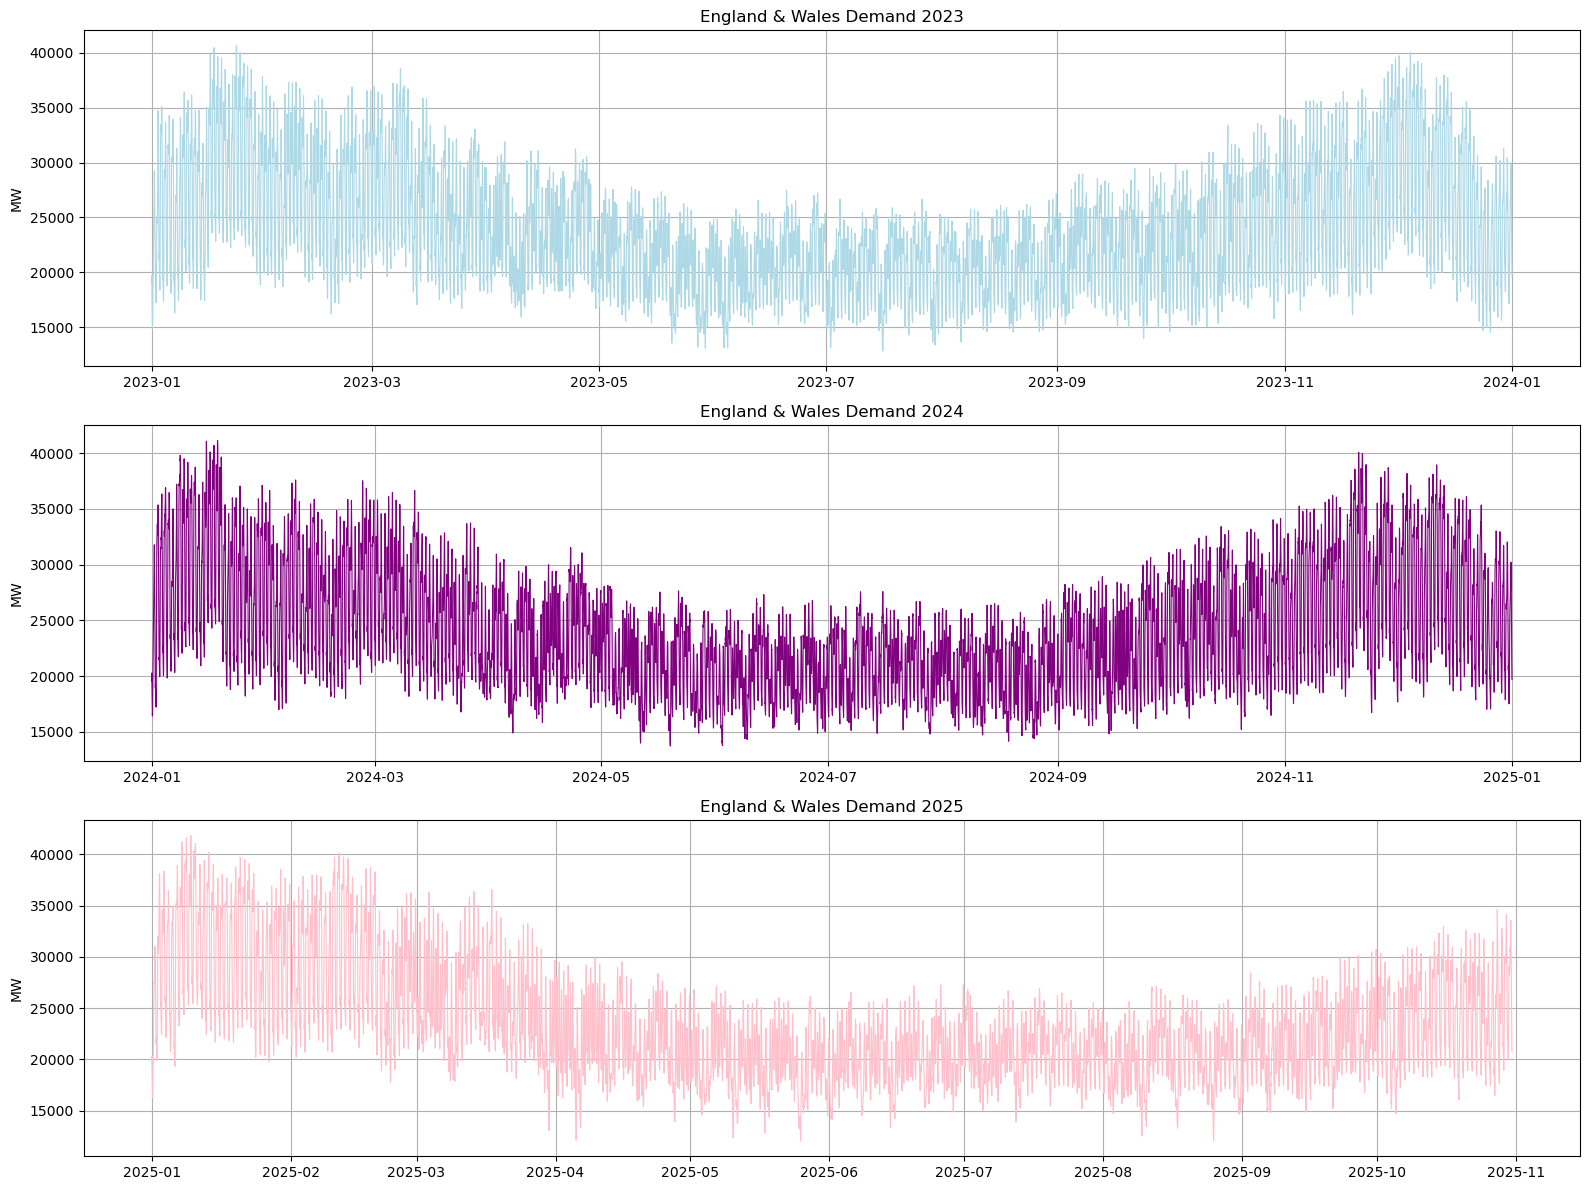

In [15]:
import matplotlib.pyplot as plt

df_2023=df[df['datetime'].dt.year==2023]
df_2024=df[df['datetime'].dt.year==2024]
df_2025=df[df['datetime'].dt.year==2025]

fig,axes=plt.subplots(3,1,figsize=(16,12))

#2023
axes[0].plot(df_2023['datetime'],df_2023['ENGLAND_WALES_DEMAND'],color='lightblue', linewidth=0.8)
axes[0].set_title('England & Wales Demand 2023')
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].grid(True)

#2024
axes[1].plot(df_2024['datetime'],df_2024['ENGLAND_WALES_DEMAND'],color='purple', linewidth=0.8)
axes[1].set_title('England & Wales Demand 2024')
axes[1].set_xlabel('')
axes[1].set_ylabel('MW')
axes[1].grid(True)

#2025
axes[2].plot(df_2025['datetime'],df_2025['ENGLAND_WALES_DEMAND'],color='pink', linewidth=0.8)
axes[2].set_title('England & Wales Demand 2025')
axes[2].set_xlabel('')
axes[2].set_ylabel('MW')
axes[2].grid(True)

plt.tight_layout()
plt.show()

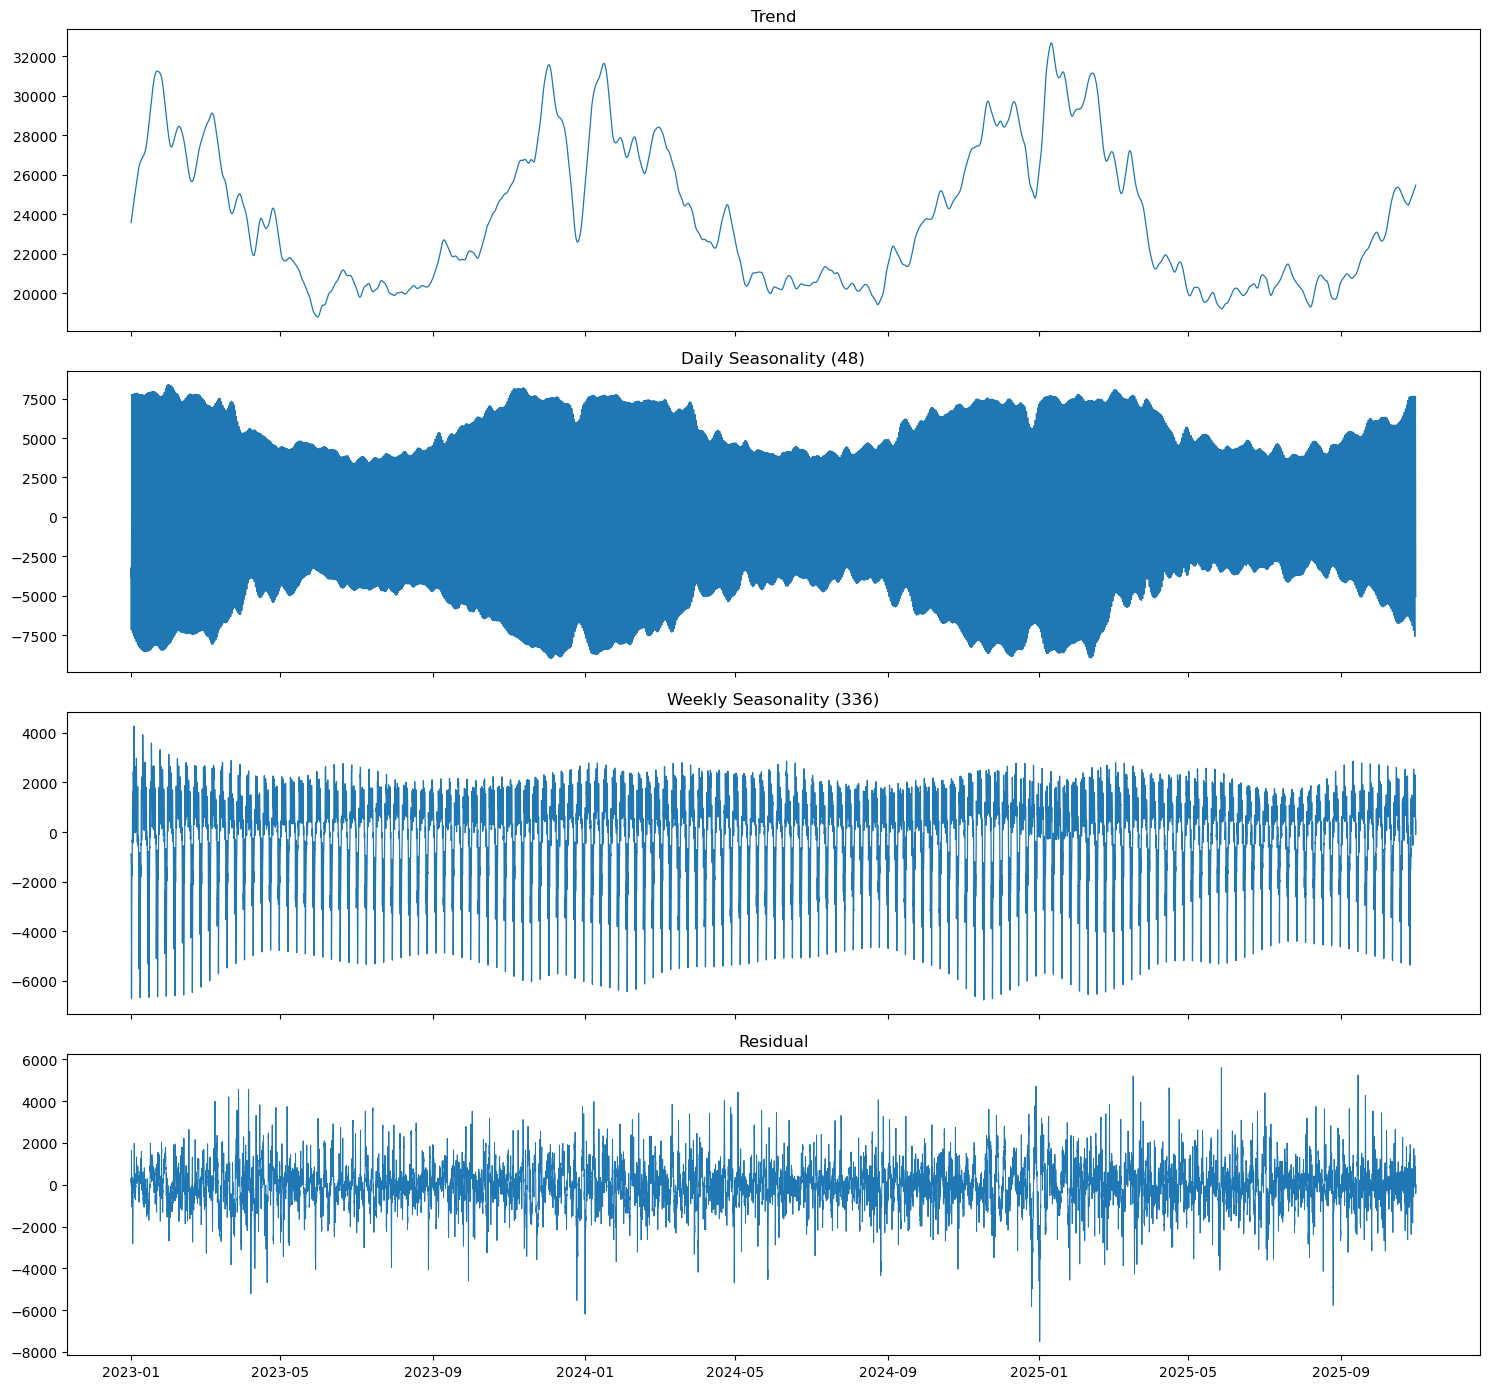

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import MSTL


df['datetime'] = pd.to_datetime(df['datetime'], utc=True, errors='coerce')
df['datetime'] = df['datetime'].dt.tz_localize(None)
df = df.set_index('datetime')



ts = df['ENGLAND_WALES_DEMAND']

mstl = MSTL(
    ts,
    periods=[48, 336],
    stl_kwargs={
        "seasonal_deg": 1,
        "trend_deg": 1,
        "trend_jump": 5
    }
)

res = mstl.fit()


trend = res.trend
seasonal_daily = res.seasonal['seasonal_48']
seasonal_weekly = res.seasonal['seasonal_336']
residual = res.resid


fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True)

axes[0].plot(trend, linewidth=0.9)
axes[0].set_title('Trend')

axes[1].plot(seasonal_daily, linewidth=0.9)
axes[1].set_title('Daily Seasonality (48)')

axes[2].plot(seasonal_weekly, linewidth=0.9)
axes[2].set_title('Weekly Seasonality (336)')

axes[3].plot(residual, linewidth=0.7)
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [17]:
# 5. plot seasonal patterns
# demand by time of day
# demand by day of week
# demand by month of year
# to identify regular fluctuations in demand associated with daily routines, weekly work patterns, seasonal changes

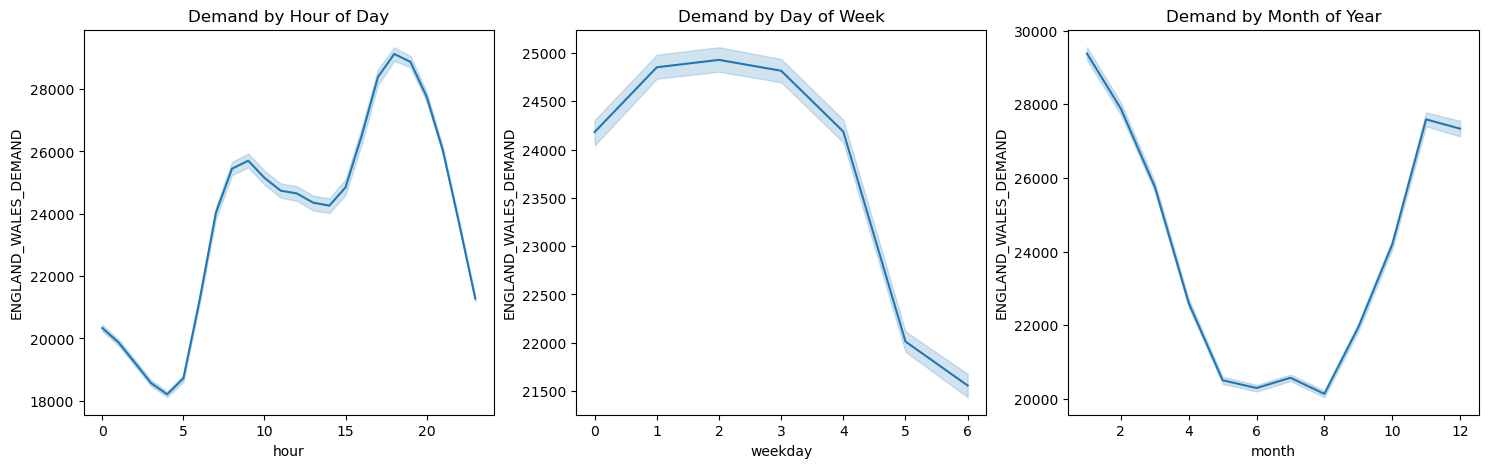

In [18]:
fig,axes=plt.subplots(1,3,figsize=(18,5))
sns.lineplot(data=df,x='hour',y='ENGLAND_WALES_DEMAND',ax=axes[0])
axes[0].set_title('Demand by Hour of Day')
sns.lineplot(data=df,x='weekday',y='ENGLAND_WALES_DEMAND',ax=axes[1])
axes[1].set_title('Demand by Day of Week')
sns.lineplot(data=df,x='month',y='ENGLAND_WALES_DEMAND',ax=axes[2])
axes[2].set_title('Demand by Month of Year')
plt.tight_layout
plt.show()

In [19]:
# 6. plot weather vs demand
# scatter plots of temperature, wind speed, solar radiation vs ENGLAND_WALES_DEMAND
# to identify relationships between weather conditions and energy demand patterns

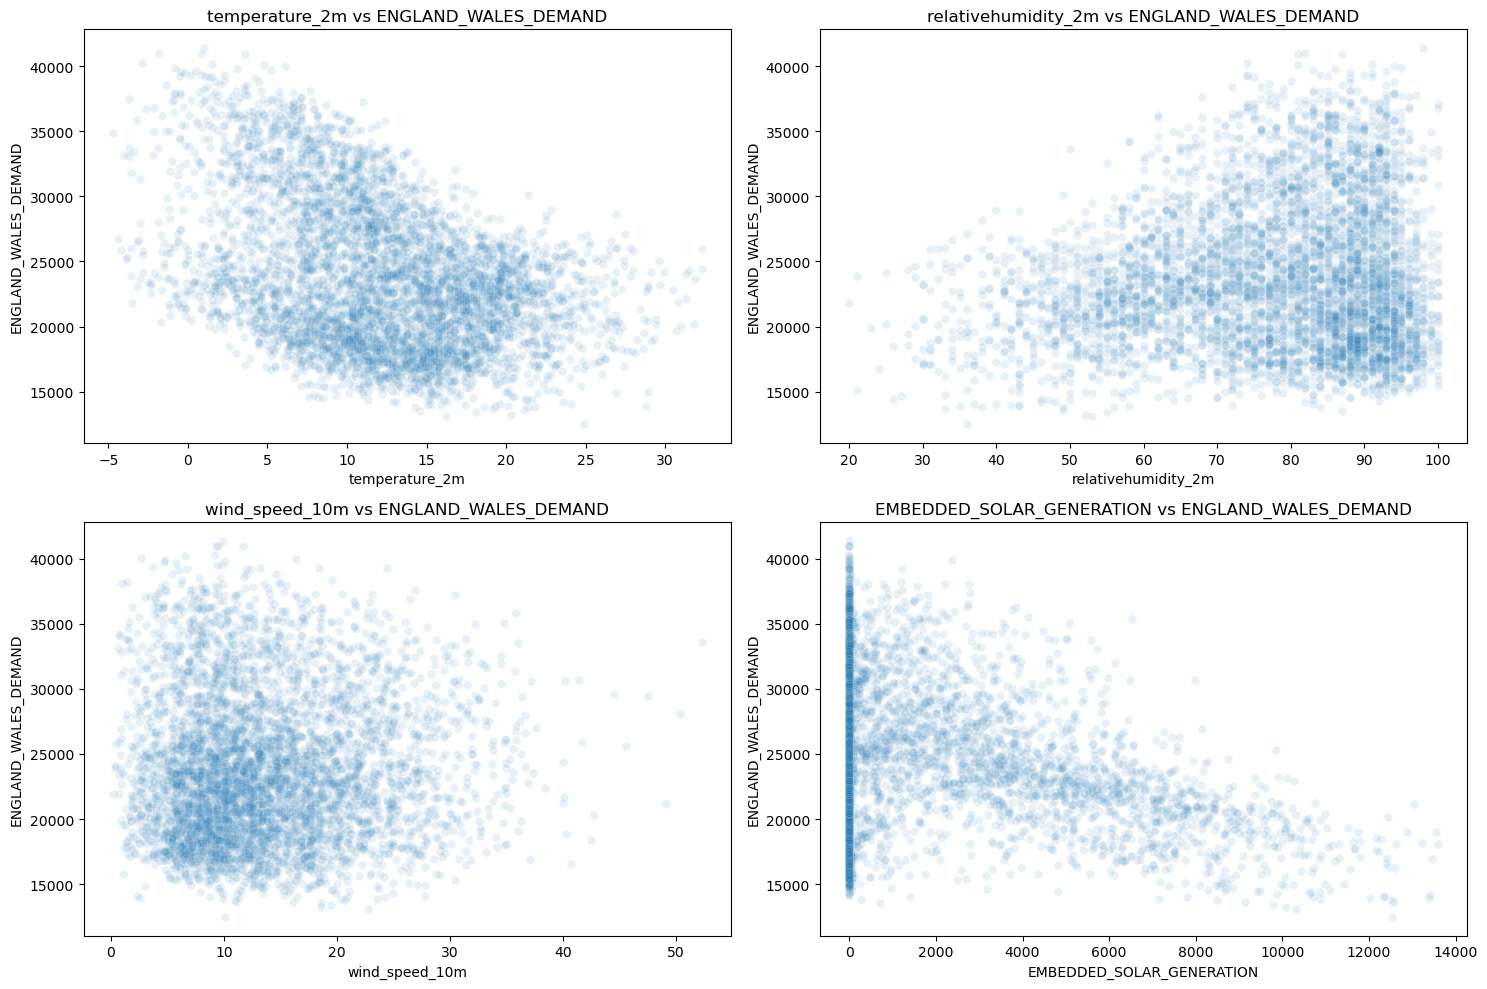

In [20]:
weather_vars= ['temperature_2m','relativehumidity_2m','wind_speed_10m', 'EMBEDDED_SOLAR_GENERATION']
fig,axes=plt.subplots(2,2,figsize=(15,10))
axes=axes.flatten()
for i,col in enumerate(weather_vars):
    sns.scatterplot(data=df.iloc[::10],x=col,y='ENGLAND_WALES_DEMAND',alpha=0.1,ax=axes[i])
    axes[i].set_title(f'{col} vs ENGLAND_WALES_DEMAND')
plt.tight_layout()
plt.show()


In [21]:
# 7. summary statistics
# mean, median, stddev, min, max of key variables
# to understand central tendencies and variability in energy demand and weather conditions

In [22]:
# Select key variables
key_vars = [
    "ENGLAND_WALES_DEMAND",
    "EMBEDDED_WIND_GENERATION",
    "EMBEDDED_SOLAR_GENERATION",
    "NON_BM_STOR",
    "temperature_2m",
    "relativehumidity_2m",
    "pressure_msl",
    "wind_speed_10m",
    "wind_direction_10m",
    "precipitation"
]

# Filter only variables that actually exist in the dataframe
key_vars = [v for v in key_vars if v in df.columns]

# Compute summary statistics
summary = df[key_vars].agg(["mean", "median", "std", "min", "max"]).T   # .T --> transpose

# Print Summary
print("\nSummary Statistics (Mean, Median, Standard Deviation, Min, Max):\n")
print(summary.round(2))


Summary Statistics (Mean, Median, Standard Deviation, Min, Max):

                               mean   median      std      min      max
ENGLAND_WALES_DEMAND       23791.38  22891.0  5472.45  12040.0  41835.0
EMBEDDED_WIND_GENERATION    1839.09   1516.0  1191.31    125.0   5962.0
EMBEDDED_SOLAR_GENERATION   1809.79     18.0  2786.53      0.0  14035.0
NON_BM_STOR                    0.00      0.0     0.01      0.0      2.0
temperature_2m                12.20     12.0     6.19     -5.0     33.6
relativehumidity_2m           77.14     81.0    15.47     17.0    100.0
pressure_msl                1014.83   1015.8    11.46    953.8   1046.0
wind_speed_10m                13.69     12.3     7.28      0.0     52.3
wind_direction_10m           190.12    218.0    92.03      1.0    360.0
precipitation                  0.09      0.0     0.35      0.0      9.7


In [23]:
# 8.distribution plots
# histograms/kde plots of ENGLAND_WALES_DEMAND, temperature, wind speed, solar radiation
# to visualize data distributions and identify skewness, kurtosis, outliers

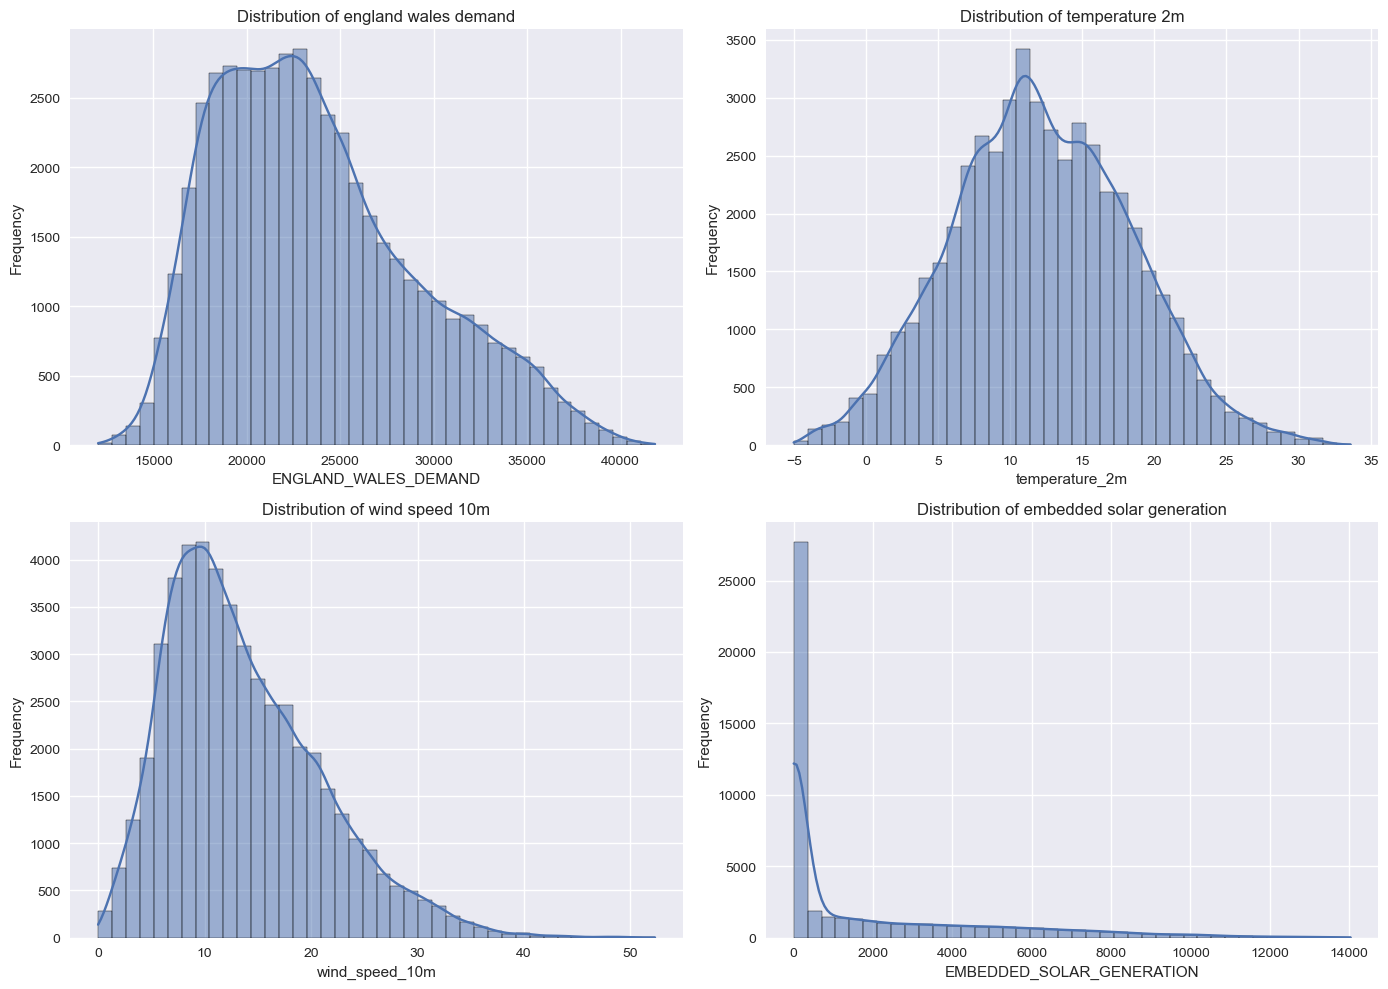

In [24]:
# Select variables for distribution plots
dist_vars = [
    "ENGLAND_WALES_DEMAND",
    "temperature_2m",
    "wind_speed_10m",
    "EMBEDDED_SOLAR_GENERATION"   # using solar generation as solar radiation proxy
]

# Plot settings
plt.style.use("seaborn-v0_8")
plt.figure(figsize=(14, 10))

for i, var in enumerate(dist_vars, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=40)
    var_name = var.replace("_", " ").lower()
    plt.title(f"Distribution of {var_name}")
    plt.xlabel(var)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [25]:
# 9. box plots
# box plots of ENGLAND_WALES_DEMAND by month
# to identify monthly variations and outliers in demand patterns

# wq:nid 1 or 3 box plot? cuz around 3 years

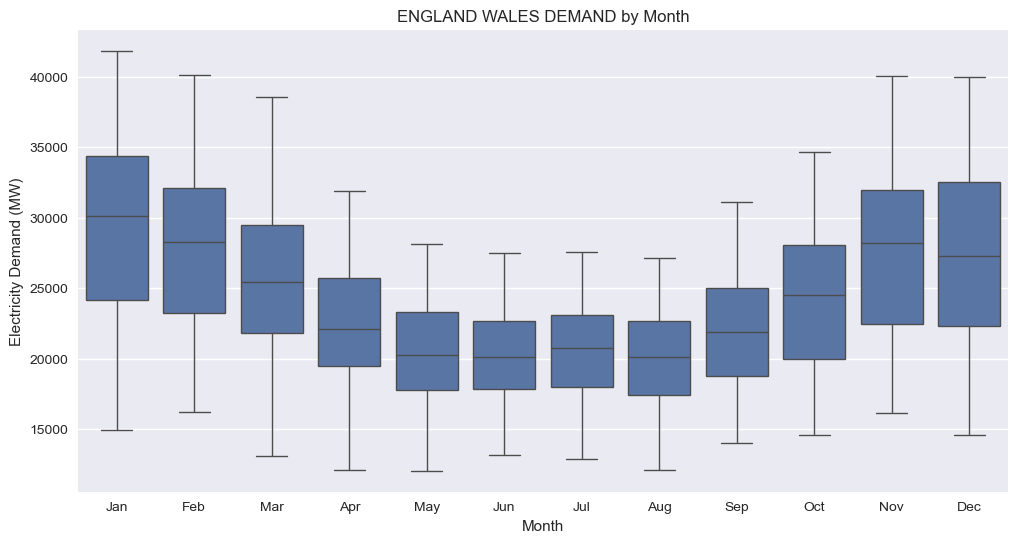

In [26]:
# Ensure your datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'])

# Extract month from datetime
# df['month'] = df.index.month


# Set plot style
# plt.style.use("seaborn-v0_8")
plt.figure(figsize=(12, 6))

# Create box plot
sns.boxplot(x='month', y='ENGLAND_WALES_DEMAND', data=df)
plt.title('ENGLAND WALES DEMAND by Month')
plt.xlabel('Month')
plt.ylabel('Electricity Demand (MW)')
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
])
plt.show()

In [27]:
# 10. correlation
# check pearson correlation between Demand and weather variables

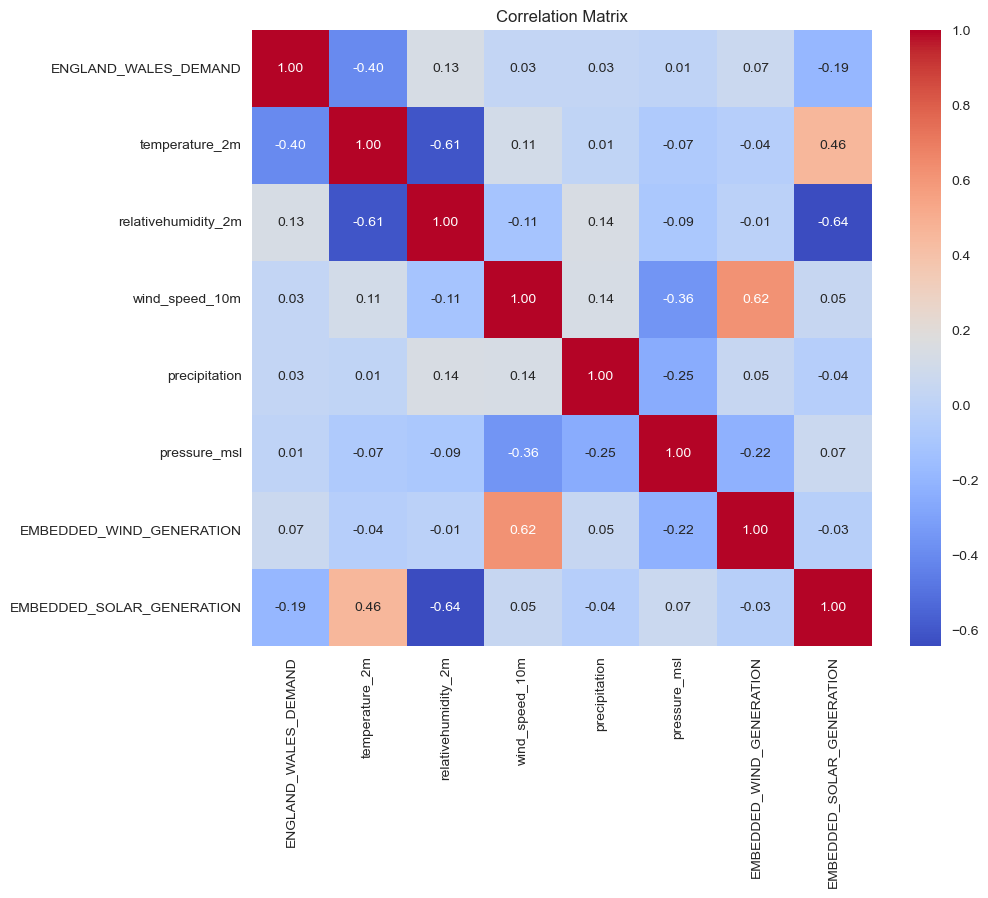

In [28]:
corr_cols=['ENGLAND_WALES_DEMAND','temperature_2m','relativehumidity_2m','wind_speed_10m','precipitation','pressure_msl','EMBEDDED_WIND_GENERATION','EMBEDDED_SOLAR_GENERATION']
plt.figure(figsize=(10,8))
sns.heatmap(df[corr_cols].corr(),annot=True,cmap='coolwarm',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [29]:
# 11. stationarity check
# to determine if the time series data (e.g., ENGLAND_WALES_DEMAND) is stationary, which is important for time series modeling
# using ADF test or KPSS test
# rolling mean and stddev plots

In [30]:
from statsmodels.tsa.stattools import adfuller
series=df['ENGLAND_WALES_DEMAND'].dropna()
result=adfuller(series.iloc[:10000],autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] <= 0.05:
    print("The time series is stationary.")
else:
    print("The time series is non-stationary.")

ADF Statistic: -2.828960706816031
p-value: 0.05425453386695383
The time series is non-stationary.


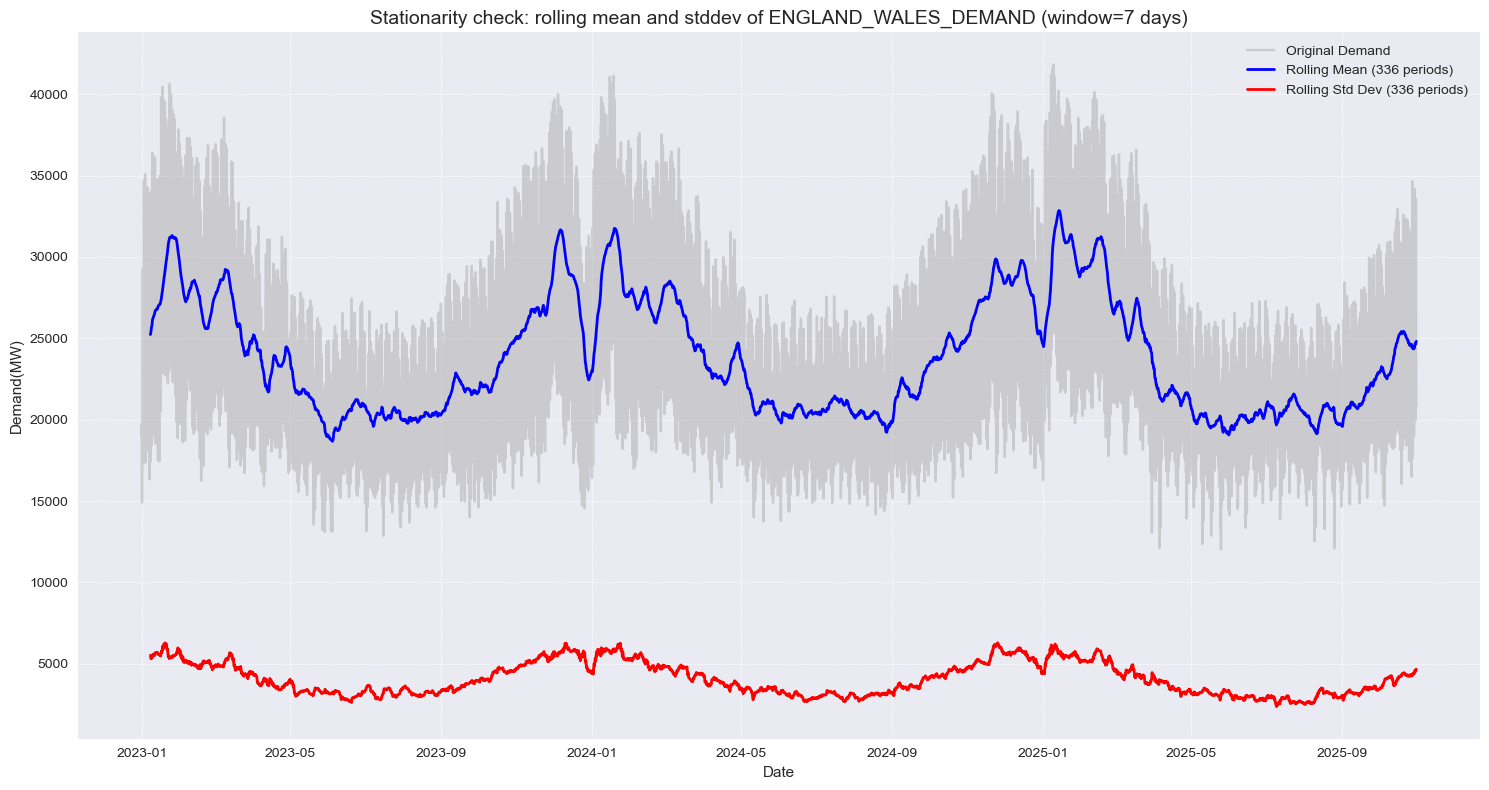

#remark
1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.
2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)
3.seasonality:repeating waves in rolling mean indicate seasonality


In [31]:
target_col='ENGLAND_WALES_DEMAND'
window_size=48*7  # one week of half-hourly data

if 'datetime' not in df.columns:
    df = df.reset_index()

rolling_mean=df[target_col].rolling(window=window_size).mean()
rolling_std=df[target_col].rolling(window=window_size).std()


plt.figure(figsize=(15,8))
plt.plot(df['datetime'],df[target_col], label='Original Demand', alpha=0.3,color='gray')
plt.plot(df['datetime'],rolling_mean, label=f'Rolling Mean ({window_size} periods)', color='blue',linewidth=2)
plt.plot(df['datetime'],rolling_std, label=f'Rolling Std Dev ({window_size} periods)', color='red',linewidth=2)
plt.title(f'Stationarity check: rolling mean and stddev of {target_col} (window=7 days)',fontsize=14)
plt.xlabel('Date')
plt.ylabel('Demand(MW)')
plt.legend(loc='best')
plt.grid(True,which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()
print("#remark")
print("1.trend:if the blue line(rolling mean) shows a consistent upward or downward slope over time, it indicates a trend in the data.")
print("2.variance:if red line(rolling std) increases or decreases over time, series has changing variance(heteroscedasticity/non stationary)")
print("3.seasonality:repeating waves in rolling mean indicate seasonality")

# Part A

## Train Test Split

In [32]:

target = 'ENGLAND_WALES_DEMAND'

# Features
time_features = ['hour', 'day', 'month','year','is_weekend','weekday']
weather_features = ['temperature_2m', 'relativehumidity_2m', 'pressure_msl',
                    'wind_speed_10m', 'wind_direction_10m', 'precipitation']
grid_features = [
    'EMBEDDED_WIND_GENERATION', 'EMBEDDED_WIND_CAPACITY',
    'EMBEDDED_SOLAR_GENERATION', 'EMBEDDED_SOLAR_CAPACITY',
    'NON_BM_STOR', 'PUMP_STORAGE_PUMPING', 'SCOTTISH_TRANSFER',
    'IFA_FLOW', 'IFA2_FLOW', 'BRITNED_FLOW', 'MOYLE_FLOW',
    'EAST_WEST_FLOW', 'NEMO_FLOW', 'NSL_FLOW', 'ELECLINK_FLOW',
    'VIKING_FLOW', 'GREENLINK_FLOW'
]

feature_cols = weather_features + time_features + grid_features

model_df = df.dropna(subset=feature_cols + [target]).copy()

# split based on the date time
# 2023, 2024 -> train
train_df = model_df[model_df.year.isin([2023, 2024])].sort_values("datetime")
print(train_df.head())

# 2025 -> test
test_df = model_df[model_df.year == 2025].sort_values("datetime")
print(test_df.head())

# train set
X_train = train_df[feature_cols]
y_train = train_df[target]

# test set
X_test = test_df[feature_cols]
y_test = test_df[target]

print(f"Train Set: {X_train.shape}")
print(f"Test Set: {X_test.shape}")


             datetime           SETTLEMENT_DATE  SETTLEMENT_PERIOD     ND  \
0 2023-01-01 00:00:00 2023-01-01 00:00:00+00:00                  1  21043   
1 2023-01-01 00:30:00 2023-01-01 00:00:00+00:00                  2  21756   
2 2023-01-01 01:00:00 2023-01-01 00:00:00+00:00                  3  21348   
3 2023-01-01 01:30:00 2023-01-01 00:00:00+00:00                  4  20586   
4 2023-01-01 02:00:00 2023-01-01 00:00:00+00:00                  5  19781   

     TSD  ENGLAND_WALES_DEMAND  EMBEDDED_WIND_GENERATION  \
0  24680                 18995                      2815   
1  25289                 19730                      2793   
2  25269                 19327                      2773   
3  24574                 18589                      2753   
4  24135                 17806                      2712   

   EMBEDDED_WIND_CAPACITY  EMBEDDED_SOLAR_GENERATION  EMBEDDED_SOLAR_CAPACITY  \
0                    6545                          0                    15037   
1             

## Scaling

In [33]:
#Scaling
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1,1))


## Create Sequences for LSTM

In [34]:
def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(len(X) - timesteps):
        X_seq.append(X[i:i+timesteps])
        y_seq.append(y[i+timesteps])
    return np.array(X_seq), np.array(y_seq)


## Helper function for evaluation

In [35]:
def timed_fit(model, X, y):
    start = time.time()
    model.fit(X, y)
    end = time.time()
    return end - start


def timed_predict(model, X):
    start = time.time()
    pred = model.predict(X)
    end = time.time()
    return pred, (end - start) / len(X)


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "R2": r2_score(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def pack_result_row(model_name, metrics, train_time, inference_time, model_size):
    row = {"Model": model_name}
    row.update(metrics)
    row.update({
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": model_size,
    })
    return row


def get_model_size_mb(model):
    """Generalized model size checker for sklearn, xgboost, keras."""
    try:
        with tempfile.NamedTemporaryFile(delete=False) as tmp:
            tmp.close()

            if isinstance(model, tf.keras.Model):
                filepath = tmp.name + ".h5"
                model.save(filepath)
                size = os.path.getsize(filepath)
                os.remove(filepath)
            else:
                joblib.dump(model, tmp.name)
                size = os.path.getsize(tmp.name)

            if os.path.exists(tmp.name):
                os.remove(tmp.name)

        return size / (1024 * 1024)

    except Exception as e:
        print(f"[Size Error] {e}")
        return np.nan

## Neural classes

In [36]:
# Neural classes (MLP, LSTM_Model, TemporalCNN)
class MLP:
    def __init__(self, input_shape,hidden_units=32, epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.hidden_units=hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(self.hidden_units, activation='relu', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_mlp_model.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size

class LSTM_Model:
    def __init__(self, input_shape,units=50, epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.epochs = epochs
        self.units=units
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            LSTM(self.units, activation='tanh', input_shape=self.input_shape),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test)
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_lstm_model.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size


class TemporalCNN:
    def __init__(self, input_shape,filters=32,epochs=50, batch_size=32):
        self.input_shape = input_shape
        self.filters=filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv1D(self.filters, kernel_size=1, activation='relu', input_shape=self.input_shape),
            Conv1D(self.filters//2, kernel_size=1, activation='relu'),
            Flatten(),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        return model

    def fit_predict(self, X_train, y_train, X_test):
        start_train = time.time()
        self.model.fit(X_train, y_train, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        training_time = time.time() - start_train

        start_pred = time.time()
        y_pred = self.model.predict(X_test).flatten()
        inference_time = (time.time() - start_pred) / X_test.shape[0]
        return y_pred, training_time, inference_time

    def get_model_size(self):
        tmp_path = "temp_temporal_cnn.keras"
        self.model.save(tmp_path)
        size = os.path.getsize(tmp_path) / 1e6
        os.remove(tmp_path)
        return size

## Train model function

In [37]:
def train_model(
    X_test, y_test,
    X_train, y_train,
    X_test_scaled, X_train_scaled,
    y_train_scaled, scaler_y,
    scale=True
):

    models = {
        "Linear Regression": LinearRegression(),
        "SVR": LinearSVR(max_iter=5000),
        "Ridge Regression": Ridge(alpha=1.0),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            tree_method=XGBOOST_TREE_METHOD
        ),
        "Random Forest": RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        ),
        "MLP": "MLP",
        "Temporal CNN": "Temporal CNN"
    }

    results_list = []
    predictions = {}
    models_dict = {}

    for name, model in models.items():
        print(f"\n===== Training {name} =====")

        # Classical ML models
        if name not in ["MLP", "Temporal CNN"]:

            # Train
            train_time = time.time()
            model.fit(X_train, y_train)
            train_time = time.time() - train_time

            # Predict
            pred_start = time.time()
            y_pred = model.predict(X_test)
            inference_time = (time.time() - pred_start) / len(X_test)

            # Save
            predictions[name] = y_pred
            models_dict[name] = model

            # Metrics
            metrics = compute_metrics(y_test, y_pred)
            model_size = get_model_size_mb(model)
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )

        # MLP Neural Network
        elif name == "MLP":
            mlp = MLP(input_shape=(X_train_scaled.shape[1],))
            y_pred_scaled, train_time, inference_time = mlp.fit_predict(
                X_train_scaled, y_train_scaled, X_test_scaled
            )

            # Inverse scale
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

            predictions[name] = y_pred
            models_dict[name] = mlp

            metrics = compute_metrics(y_test, y_pred)
            model_size = mlp.get_model_size()
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )

        # Temporal CNN
        elif name == "Temporal CNN":
            X_train_seq = X_train_scaled.reshape(len(X_train_scaled), 1, -1)
            X_test_seq  = X_test_scaled.reshape(len(X_test_scaled), 1, -1)

            cnn = TemporalCNN(input_shape=(1, X_train_scaled.shape[1]))
            y_pred_scaled, train_time, inference_time = cnn.fit_predict(
                X_train_seq, y_train_scaled, X_test_seq
            )

            # Inverse scale
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

            predictions[name] = y_pred
            models_dict[name] = cnn

            metrics = compute_metrics(y_test, y_pred)
            model_size = cnn.get_model_size()
            results_list.append(
                pack_result_row(name, metrics, train_time, inference_time, model_size)
            )


    return predictions, results_list, models_dict

In [38]:
# LSTM training wrapper
def train_LSTM(
    predictions, results_list,
    X_train_raw, X_test_raw,
    y_train_raw, y_test_raw,
    scaler_y,
    timesteps=24, scale=True
):
    # Ensure inputs are numpy arrays for create_sequences
    X_train_np = X_train_raw if isinstance(X_train_raw, np.ndarray) else X_train_raw.to_numpy()
    X_test_np  = X_test_raw if isinstance(X_test_raw, np.ndarray) else X_test_raw.to_numpy()
    y_train_np = y_train_raw if isinstance(y_train_raw, np.ndarray) else y_train_raw.to_numpy()
    y_test_np  = y_test_raw if isinstance(y_test_raw, np.ndarray) else y_test_raw.to_numpy()

    # Create sequences
    X_train_seq, y_train_seq = create_sequences(X_train_np, y_train_np, timesteps)
    X_test_seq, y_test_seq   = create_sequences(X_test_np, y_test_np, timesteps)

    # Initialize LSTM model with correct input shape (timesteps, features)
    lstm = LSTM_Model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

    y_pred_scaled, train_time, inference_time = lstm.fit_predict(
        X_train_seq, y_train_seq, X_test_seq
    )

    # Inverse scale predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()

    # Add prediction
    predictions["LSTM"] = y_pred

    # Inverse scale y_test_seq for metric computation if scaled
    # y_test_seq contains the actual values corresponding to the predictions made
    y_test_actual = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).flatten() if scale else y_test_seq

    # Compute metrics
    metrics = compute_metrics(y_test_actual, y_pred)

    results_list.append({
        "Model": "LSTM",
        **metrics,
        "Training Time (s)": train_time,
        "Inference Time per Sample (s)": inference_time,
        "Model Size (MB)": lstm.get_model_size()
    })

    return predictions, results_list

## A. Raw data training

In [39]:
# Part A - Step 1: Train on raw data (no preprocess)
XGBOOST_TREE_METHOD = 'hist'

# Use original X_train, X_test, y_train, y_test (no scaling)
predictions_raw, results_list_raw, models_dict_raw = train_model(
    X_test, y_test,
    X_train, y_train,
    X_test.to_numpy(), X_train.to_numpy(),
    y_train.to_numpy().reshape(-1, 1), scaler_y,
    False
)

# Add LSTM (no scaling)
predictions_raw, results_list_raw = train_LSTM(
    predictions_raw, results_list_raw,
    X_train.to_numpy(), X_test.to_numpy(), # Convert DataFrames to NumPy arrays
    y_train.to_numpy(), y_test.to_numpy(), # Convert Series to NumPy arrays
    scaler_y, timesteps=24, scale=False
)

result_table_1 = pd.DataFrame(results_list_raw)
print("Result Table 1 - Raw data (no preprocess):")
display(result_table_1)


===== Training Linear Regression =====

===== Training SVR =====


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== Training Ridge Regression =====

===== Training Decision Tree =====

===== Training XGBoost =====

===== Training Random Forest =====

===== Training MLP =====


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step

===== Training Temporal CNN =====


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Result Table 1 - Raw data (no preprocess):


,Model,MAE,MSE,RMSE,R2,MAPE,Training Time (s),Inference Time per Sample (s),Model Size (MB)
0,Linear Regression,1.374217e+04,2.330029e+08,1.526443e+04,-6.870027e+00,0.651749,0.055480,2.176502e-07,0.001786
1,SVR,4.266395e+03,2.786098e+07,5.278350e+03,5.895275e-02,0.192544,34.668628,1.958327e-07,0.001629
2,Ridge Regression,1.357505e+04,2.275412e+08,1.508447e+04,-6.685553e+00,0.643809,0.015944,1.709008e-07,0.001588
3,Decision Tree,1.611441e+03,4.562386e+06,2.135974e+03,8.458985e-01,0.071195,0.691751,3.106900e-07,4.810029
4,XGBoost,1.288682e+03,2.690370e+06,1.640235e+03,9.091287e-01,0.054946,0.280981,8.343257e-07,0.457026
5,Random Forest,1.228089e+03,2.609699e+06,1.615456e+03,9.118534e-01,0.053947,7.363486,5.811496e-06,303.985612
6,MLP,6.781988e+08,4.750561e+17,6.892431e+08,-1.604574e+10,29731.771484,45.314142,2.657702e-05,0.032783
7,Temporal CNN,6.142065e+08,4.002203e+17,6.326297e+08,-1.351805e+10,26604.810547,65.976084,2.928642e-05,0.045976
8,LSTM,3.931438e+07,1.545639e+15,3.931462e+07,-5.218212e+07,1775.638916,232.790000,8.737667e-05,0.216784


## B. Post preprocessing training

In [40]:
# Part A - Step 2: Minimal preprocessing (outlier handling, scaling, simple transform, feature selection)

def iqr_clip_df(df_in, cols):
    df = df_in.copy()
    for c in cols:
        q1 = df[c].quantile(0.25)
        q3 = df[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        df[c] = df[c].clip(lower, upper)
    return df

# Apply IQR clipping to train_df (only features)
train_df_clipped = train_df.copy()
train_df_clipped[feature_cols] = iqr_clip_df(train_df_clipped[feature_cols], feature_cols)

# Re-derive X_train_minpreproc, y_train_minpreproc, X_test_minpreproc, y_test_minpreproc
X_train_min = train_df_clipped[feature_cols]
y_train_min = train_df_clipped[target]

# For test we keep original test_df (no leakage)
X_test_min = X_test.copy()
y_test_min = y_test.copy()

# Recompute scaling on this minimally preprocessed train if desired
X_train_min_scaled = scaler_X.transform(X_train_min)
X_test_min_scaled  = scaler_X.transform(X_test_min)
y_train_min_scaled = scaler_y.transform(y_train_min.values.reshape(-1,1))
y_test_min_scaled  = scaler_y.transform(y_test_min.values.reshape(-1,1))

# Train again using scaled flag True (so neural nets receive scaled arrays)
predictions_minpre, results_list_minpre, models_dict_minpre = train_model(
    X_test_min, y_test_min,
    X_train_min, y_train_min,
    X_test_min_scaled, X_train_min_scaled,
    y_train_min_scaled, scaler_y, True
)

predictions_minpre, results_list_minpre = train_LSTM(
    predictions_minpre, results_list_minpre,
    X_train_min_scaled, X_test_min_scaled,
    y_train_min_scaled, y_test_min_scaled,
    scaler_y, timesteps=24, scale=True
)

result_table_2 = pd.DataFrame(results_list_minpre)
print("Result Table 2 - Minimal preprocess (IQR clipping + scaling):")
display(result_table_2)



===== Training Linear Regression =====

===== Training SVR =====


c:\Users\wenqi\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



===== Training Ridge Regression =====

===== Training Decision Tree =====

===== Training XGBoost =====

===== Training Random Forest =====

===== Training MLP =====


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step

===== Training Temporal CNN =====


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step


c:\Users\wenqi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


454/454 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Result Table 2 - Minimal preprocess (IQR clipping + scaling):


,Model,MAE,MSE,RMSE,R2,MAPE,Training Time (s),Inference Time per Sample (s),Model Size (MB)
0,Linear Regression,6964.550992,6.606920e+07,8128.295963,-1.231588,0.332648,0.021430,1.388057e-07,0.001786
1,SVR,5644.110031,4.617595e+07,6795.288505,-0.559663,0.269677,35.365666,1.863746e-07,0.001629
2,Ridge Regression,6830.145211,6.382446e+07,7989.021440,-1.155769,0.326159,0.011383,1.664914e-07,0.001588
3,Decision Tree,1659.733242,4.842907e+06,2200.660617,0.836423,0.074305,0.707411,3.154272e-07,4.809754
4,XGBoost,1284.004517,2.816380e+06,1678.207451,0.904872,0.056432,0.170912,8.552580e-07,0.461448
5,Random Forest,1285.241482,2.804262e+06,1674.593053,0.905282,0.057442,6.767215,5.204655e-06,303.979981
6,MLP,35230.546875,1.911366e+09,43719.167787,-63.559296,1.562173,47.970420,2.509735e-05,0.032789
7,Temporal CNN,14930.120117,3.333019e+08,18256.556521,-10.257779,0.648343,82.434428,3.233610e-05,0.045980
8,LSTM,6406.508564,5.931041e+07,7701.324946,-1.002371,0.269624,232.753542,8.170689e-05,0.216786


## C. Evaluation with bias-variance tradeoff graph, model complexity vs error, ridge regularization graph

In [41]:
from sklearn.base import BaseEstimator,RegressorMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

class LSTM_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,units=32, epochs=50, batch_size=32):
        self.units=units
        self.epochs = epochs
        self.batch_size = batch_size
        self.lstm_instance = None # Store the LSTM_Model object

    def fit(self, X, y):
        # reshape to (samples, timesteps=1, features)
        X_lstm = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        self.lstm_instance = LSTM_Model(input_shape=input_shape,
                                        units=self.units,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size)
        # Train the LSTM model using its fit_predict method
        # Pass X as a dummy X_test for the fit_predict method, as only training matters here.
        self.lstm_instance.fit_predict(X_train=X_lstm, y_train=y, X_test=X_lstm)
        return self

    def predict(self, X):
        if self.lstm_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_lstm = np.expand_dims(X, axis=1)
        # Directly call the Keras model's predict method for inference
        y_pred = self.lstm_instance.model.predict(X_lstm).flatten()
        return y_pred

In [42]:
class MLP_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,hidden_units=32, epochs=50, batch_size=32):
        self.hidden_units=hidden_units
        self.epochs = epochs
        self.batch_size = batch_size
        self.mlp_instance = None # Store the MLP object

    def fit(self, X, y):
        # Initialize the MLP model
        input_shape = (X.shape[1],)
        self.mlp_instance = MLP(input_shape=input_shape,
                                hidden_units=self.hidden_units,
                                epochs=self.epochs,
                                batch_size=self.batch_size)
        # Train the MLP model using its fit_predict method
        # Pass X as a dummy X_test for the fit_predict method, as only training matters here.
        self.mlp_instance.fit_predict(X_train=X, y_train=y, X_test=X)
        return self

    def predict(self, X):
        if self.mlp_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        # Directly call the Keras model's predict method for inference
        y_pred = self.mlp_instance.model.predict(X).flatten()
        return y_pred

In [43]:
class TemporalCNN_Wrapper(BaseEstimator, RegressorMixin):
    def __init__(self,filters=16, epochs=50, batch_size=32):
        self.filters=filters
        self.epochs = epochs
        self.batch_size = batch_size
        self.cnn_instance = None # Store the TemporalCNN object

    def fit(self, X, y):
        X_cnn = np.expand_dims(X, axis=1)
        input_shape = (1, X.shape[1])
        self.cnn_instance = TemporalCNN(input_shape=input_shape,
                                        filters=self.filters,
                                        epochs=self.epochs,
                                        batch_size=self.batch_size)
        # Train the CNN model using its fit_predict method
        # Pass X_cnn as a dummy X_test for the fit_predict method, as only training matters here.
        self.cnn_instance.fit_predict(X_train=X_cnn, y_train=y, X_test=X_cnn)
        return self

    def predict(self, X):
        if self.cnn_instance is None:
            raise RuntimeError("Model has not been fitted yet.")
        X_cnn = np.expand_dims(X, axis=1)
        # Directly call the Keras model's predict method for inference
        y_pred = self.cnn_instance.model.predict(X_cnn).flatten()
        return y_pred

878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
Result Table 3 - Bias-Variance Diagnostics:


,Model,Training R2,Validation R2,Bias indicator,Variance indicator,Generalization Gap
0,Linear Regression,0.607624,0.598297,Low bias,Low variance,0.009327
1,Ridge Regression,0.607616,0.598367,Low bias,Low variance,0.009249
2,Linear SVR,0.563456,0.561192,Low bias,Low variance,0.002264
3,Decision Tree,1.000000,0.953815,Low bias,Low variance,0.046185
4,Random Forest,0.996710,0.979067,Low bias,Low variance,0.017642
5,XGBoost,0.987031,0.981866,Low bias,Low variance,0.005165
6,MLP,0.870715,0.866009,Low bias,Low variance,0.004706
7,LSTM,0.840860,0.835870,Low bias,Low variance,0.004990
8,Temporal CNN,0.886023,0.879771,Low bias,Low variance,0.006252


878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 723us/step
878/878 ━━━━━━━━━━━━━━━━━━━━ 1s 629us/step
220/220 ━━━

,Model,Complexity,Train error,Val error,Overfitting Index
0,Decision Tree,max_depth=2,1.422082e+07,1.381124e+07,4.095779e+05
1,Decision Tree,max_depth=4,8.877143e+06,8.781027e+06,9.611589e+04
2,Decision Tree,max_depth=8,3.214444e+06,3.321328e+06,-1.068835e+05
3,Decision Tree,max_depth=None,0.000000e+00,1.371363e+06,-1.371363e+06
4,Random Forest,n_estimators=10,1.483353e+05,7.104525e+05,-5.621172e+05
5,Random Forest,n_estimators=30,1.080247e+05,6.434443e+05,-5.354196e+05
6,Random Forest,n_estimators=50,9.865182e+04,6.215402e+05,-5.228884e+05
7,Random Forest,n_estimators=100,9.308011e+04,6.066139e+05,-5.135338e+05
8,XGBoost,max_depth=2,2.048994e+06,2.065037e+06,-1.604312e+04
9,XGBoost,max_depth=4,9.057886e+05,9.584487e+05,-5.266012e+04


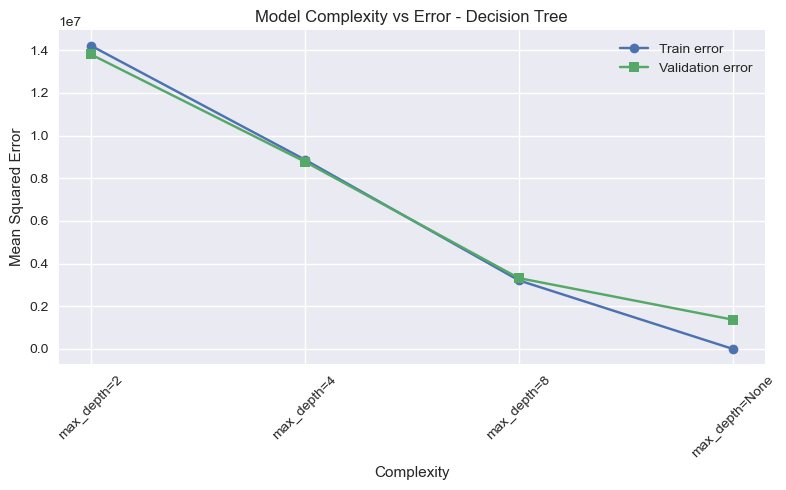

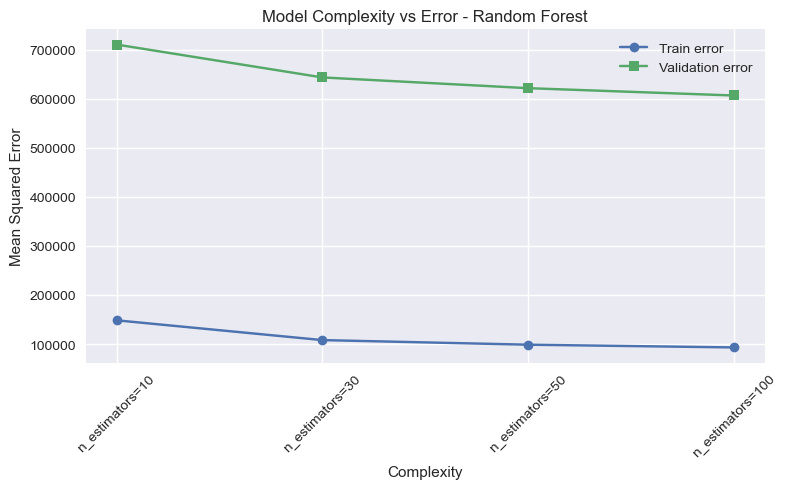

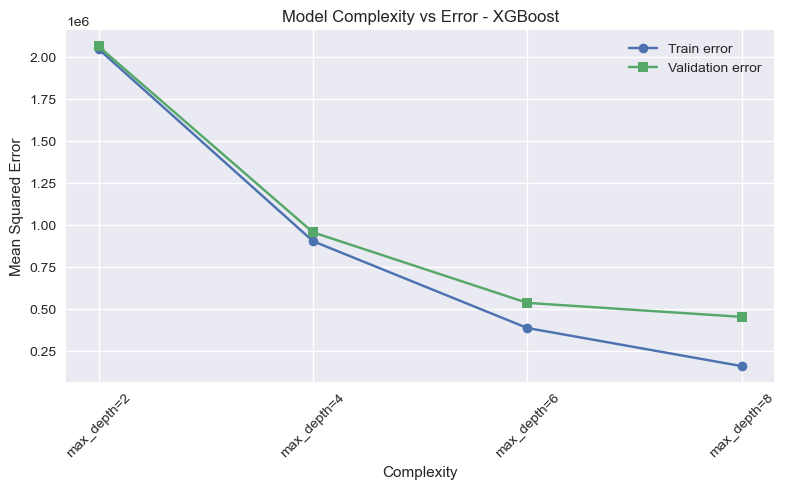

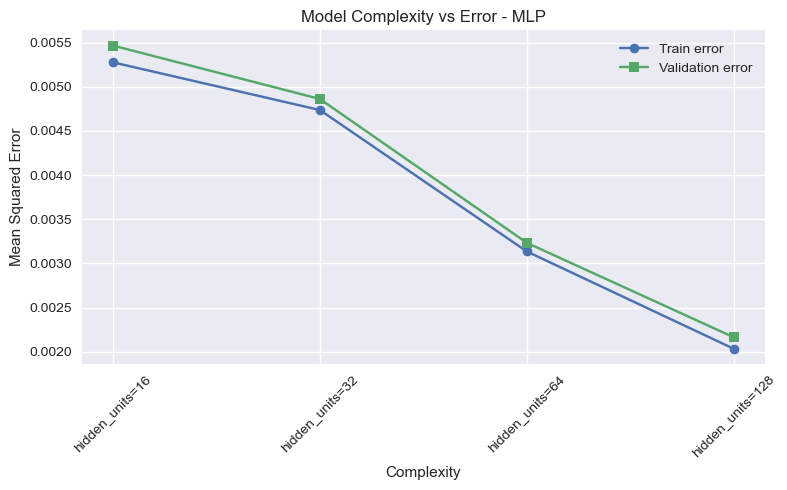

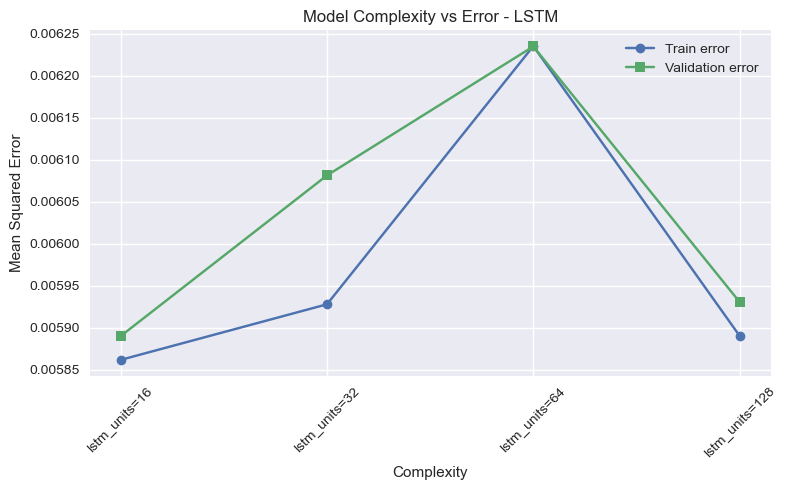

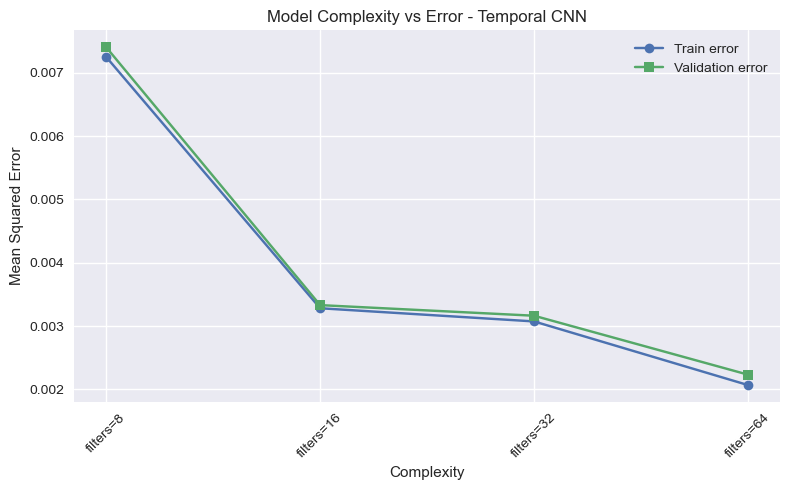

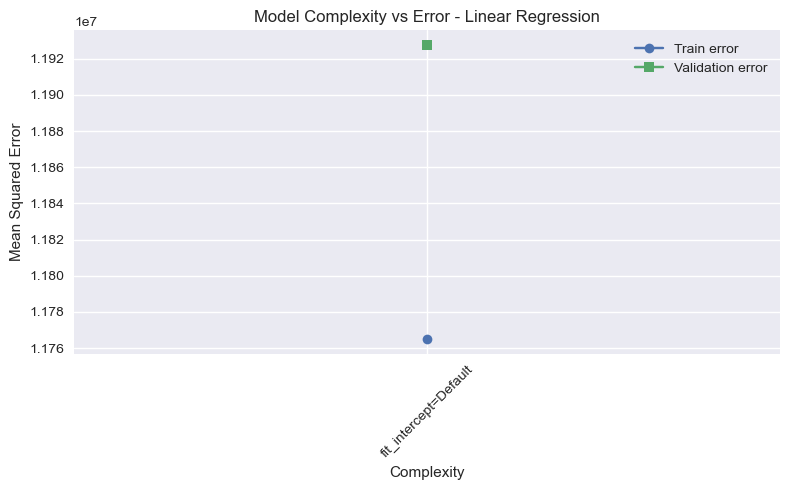

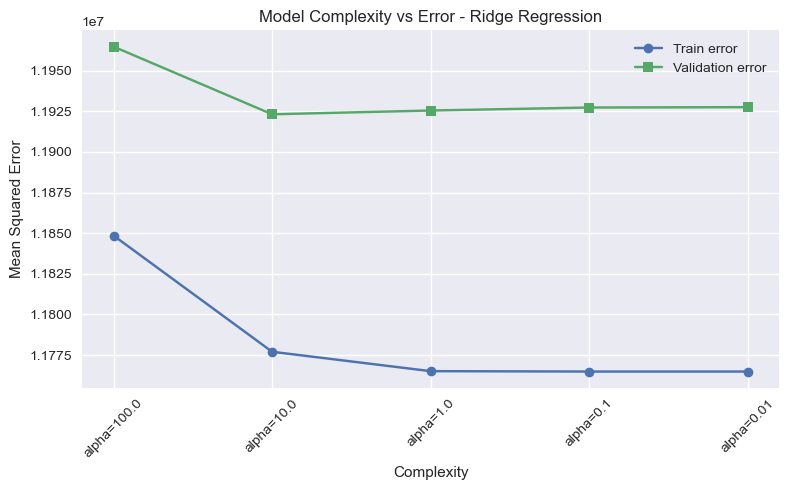

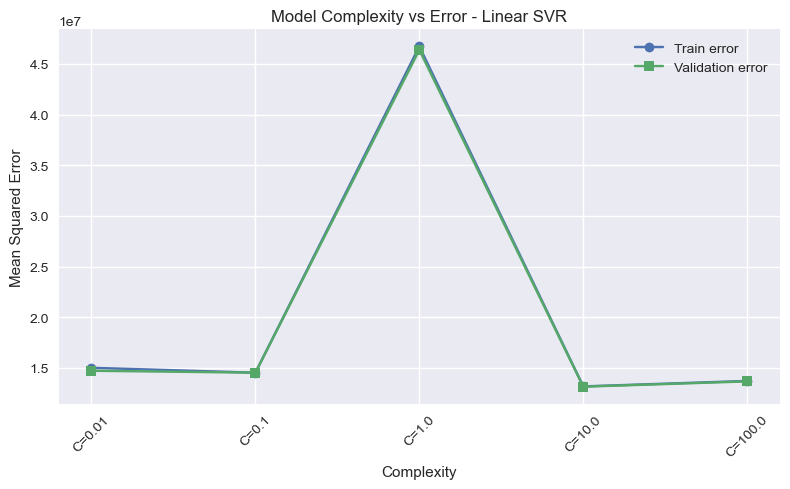

Result Table 5 - Ridge Regularization Impact:


,Alpha,Train R²,Val R²,Test R²,Coefficient Magnitude
0,0.01,0.605868,0.599132,-6.868100,593.414138
1,0.10,0.605868,0.599136,-6.850833,591.927867
2,1.00,0.605864,0.599175,-6.685553,577.586786
3,10.00,0.605597,0.599222,-5.546741,472.310983
4,100.00,0.603523,0.597903,-3.519316,236.884830


In [44]:
# Part A - Step 3: Evaluation Tables 3-5 (Bias-Variance, Complexity vs Error, Ridge Regularization Impact)
# Bias-Variance diagnostics (train vs validation R^2, generalization gap)
def bias_variance_diagnostics(model, X_train, y_train, X_val, y_val):
    # Train model on full training set and evaluate on validation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    train_r2 = r2_score(y_train, model.predict(X_train))
    val_r2 = r2_score(y_val, model.predict(X_val))
    gen_gap = train_r2 - val_r2
    bias_indicator = "High bias" if train_r2 < 0.5 and val_r2 < 0.5 else "Low bias"
    variance_indicator = "High variance" if gen_gap > 0.1 else "Low variance"
    return {"Training R2": train_r2, "Validation R2": val_r2, "Bias indicator": bias_indicator,
            "Variance indicator": variance_indicator, "Generalization Gap": gen_gap}

# Build a small validation split from train for diagnostics
# For bias-variance diagnostics, use the minimally preprocessed (scaled) data for models that benefit from it
X_tr_sub_scaled, X_val_sub_scaled, y_tr_sub_scaled, y_val_sub_scaled = train_test_split(
    X_train_min_scaled, y_train_min_scaled, test_size=0.2, random_state=42
)

diag_rows = []
complexity_rows = []

# define models to check for diagnostics
diag_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Linear SVR": LinearSVR(max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=50, tree_method="hist", random_state=42),
    "MLP": MLP_Wrapper(epochs=10),
    "LSTM": LSTM_Wrapper(epochs=10),
    "Temporal CNN": TemporalCNN_Wrapper(epochs=10)
}

for name, mod in diag_models.items():
    if name in ["MLP", "LSTM", "Temporal CNN"]:
        # Neural networks perform better with scaled data
        d = bias_variance_diagnostics(mod, X_tr_sub_scaled, y_tr_sub_scaled, X_val_sub_scaled, y_val_sub_scaled)
    else:
        # Other models can use the original (unscaled) X_tr_sub and y_tr_sub for comparison
        # Create a local split from original X_train, y_train for non-NN models
        X_tr_sub_raw, X_val_sub_raw, y_tr_sub_raw, y_val_sub_raw = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        d = bias_variance_diagnostics(mod, X_tr_sub_raw, y_tr_sub_raw, X_val_sub_raw, y_val_sub_raw)

    d_row = {"Model": name}
    d_row.update(d)
    diag_rows.append(d_row)

result_table_3 = pd.DataFrame(diag_rows)
print("Result Table 3 - Bias-Variance Diagnostics:")
display(result_table_3)

# Model-Complexity vs Error
model_configs = {
    "Decision Tree": {"max_depth": [2, 4, 8, None]},
    "Random Forest": {"n_estimators": [10, 30, 50, 100]},
    "XGBoost": {"max_depth": [2, 4, 6, 8]},
    "MLP": {"hidden_units": [16, 32, 64, 128]},
    "LSTM": {"lstm_units": [16, 32, 64, 128]},
    "Temporal CNN": {"filters": [8, 16, 32, 64]},

    # wq new added
    "Linear Regression": {"fit_intercept": ["Default"]}, 
    "Ridge Regression": {"alpha": [100.0, 10.0, 1.0, 0.1, 0.01]}, 
    "Linear SVR": {"C": [0.01, 0.1, 1.0, 10.0, 100.0]}
}

def complexity_str(model_name,value_name,value):
    return f"{value_name}={value}"

for model_name,param_dict in model_configs.items():
    for param_name, values in param_dict.items():
        for val in values:
            #neuralnet
            if model_name in ["MLP","LSTM","Temporal CNN"]:
                X_sub,y_sub=X_tr_sub_scaled,y_tr_sub_scaled
                X_val_sub_local,y_val_sub_local=X_val_sub_scaled,y_val_sub_scaled
                if model_name=="MLP":
                    model=MLP_Wrapper(hidden_units=val, epochs=10)
                elif model_name=="LSTM":
                    model=LSTM_Wrapper(units=val,epochs=10)
                elif model_name=="Temporal CNN":
                    model=TemporalCNN_Wrapper(filters=val,epochs=10)
            
            #ml
            else:
                X_sub,y_sub=X_tr_sub_raw,y_tr_sub_raw
                X_val_sub_local,y_val_sub_local=X_val_sub_raw,y_val_sub_raw
                if model_name == "Decision Tree":
                    model = DecisionTreeRegressor(max_depth=val, random_state=42)

                elif model_name == "Random Forest":
                    model = RandomForestRegressor(n_estimators=val, random_state=42)

                elif model_name == "XGBoost":
                    model = XGBRegressor(
                        max_depth=val,
                        n_estimators=50,
                        tree_method="hist",
                        random_state=42
                    )
            
            # new added
                elif model_name == "Linear Regression":
                    model = LinearRegression()
                    
                elif model_name == "Ridge Regression":
                    model = Ridge(alpha=val)
                    
                elif model_name == "Linear SVR":
                    model = LinearSVR(C=val, max_iter=5000)
            

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_sub, y_sub)

            
            # Calculate errors
            train_err = mean_squared_error(y_sub, model.predict(X_sub))
            val_err = mean_squared_error(y_val_sub_local, model.predict(X_val_sub_local))
            
            # Store
            complexity_rows.append({
                "Model": model_name,
                "Complexity":f"{param_name}={val}",
                "Train error": train_err,
                "Val error": val_err,
                "Overfitting Index": train_err - val_err
            })
cm_df = pd.DataFrame(complexity_rows)
cm_df["Complexity Level"] = cm_df.groupby("Model").cumcount() + 1

result_table_4 = pd.DataFrame(complexity_rows)
print("Result Table 4 - Model-Complexity vs Error:")
display(result_table_4)

# ---------------------------------------------------
# Plot Graph
for model in cm_df["Model"].unique():
    temp = cm_df[cm_df["Model"] == model]
    plt.figure(figsize=(8,5))
    plt.plot(temp["Complexity Level"], temp["Train error"], marker='o', linestyle='-', label='Train error')
    plt.plot(temp["Complexity Level"], temp["Val error"], marker='s', linestyle='-', label='Validation error')
    plt.xticks(temp["Complexity Level"], temp["Complexity"], rotation=45)
    plt.title(f"Model Complexity vs Error - {model}")
    plt.xlabel("Complexity")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Regularization Impact (Ridge Regression) - vary alpha and report train/val/test R2 + coef magnitude
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_rows = []
for a in alphas:
    r = Ridge(alpha=a)
    r.fit(X_train, y_train) # Ridge will always use the original (unscaled) X_train, y_train
    train_r2 = r2_score(y_train, r.predict(X_train))

    # Recalculate X_val_sub_raw for consistency with non-NN models in bias-variance diagnostics
    _, X_val_sub_raw, _, y_val_sub_raw = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    val_r2 = r2_score(y_val_sub_raw, r.predict(X_val_sub_raw))
    test_r2 = r2_score(y_test, r.predict(X_test))
    coef_mag = np.mean(np.abs(r.coef_)) if hasattr(r, 'coef_') else None
    ridge_rows.append({"Alpha": a, "Train R²": train_r2, "Val R²": val_r2, "Test R²": test_r2, "Coefficient Magnitude": coef_mag})

result_table_5 = pd.DataFrame(ridge_rows)
print("Result Table 5 - Ridge Regularization Impact:")
display(result_table_5)

In [45]:
# error analysis

In [46]:
# feature importance

## D. 5-fold cv

In [47]:
# Part A - Step 4: 5-fold cross validation table
def cross_val_summary(model, X, y, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    r2_scores = []
    mse_scores = []
    for train_idx, val_idx in kf.split(X):
        Xtr, Xv = X.iloc[train_idx], X.iloc[val_idx]
        ytr, yv = y.iloc[train_idx], y.iloc[val_idx]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(Xtr, ytr)
        preds = model.predict(Xv)
        r2_scores.append(r2_score(yv, preds))
        mse_scores.append(mean_squared_error(yv, preds))
    return {"Mean R2": np.mean(r2_scores), "Std R2": np.std(r2_scores),
            "Mean MSE": np.mean(mse_scores), "Std MSE": np.std(mse_scores)}

cv_models = {
    "Linear Regression": LinearRegression(),
    "Linear SVR": LinearSVR(max_iter=5000),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=50, random_state=42, n_jobs=-1,
                            tree_method=XGBOOST_TREE_METHOD if XGBOOST_TREE_METHOD != 'auto' else 'hist')
}

cv_rows = []
for name, mod in cv_models.items():
    summary = cross_val_summary(mod, X_train, y_train, folds=5)
    row = {"Model": name}
    row.update(summary)
    cv_rows.append(row)

result_table_6 = pd.DataFrame(cv_rows)
print("Result Table 6 - 5-fold Cross Validation Summary:")
display(result_table_6)


KeyboardInterrupt: 

## Select winner models

In [ ]:
df_table1 = result_table_1.copy()
# Quick pick via lowest RMSE per category (simple heuristics):
# Regression models: Linear Regression, Linear SVR, Ridge Regression
regression_rows = df_table1[df_table1['Model'].isin(['Linear Regression','SVR','Ridge Regression'])]
winner_regression = regression_rows.sort_values('RMSE').iloc[0]['Model'] if not regression_rows.empty else None

tree_rows = df_table1[df_table1['Model'].isin(['Decision Tree','Random Forest','XGBoost'])]
winner_tree = tree_rows.sort_values('RMSE').iloc[0]['Model'] if not tree_rows.empty else None

neural_rows = df_table1[df_table1['Model'].isin(['MLP','LSTM','Temporal CNN'])]
winner_neural = neural_rows.sort_values('RMSE').iloc[0]['Model'] if not neural_rows.empty else None

print("Winner candidates (simple RMSE heuristic):")
print("Regression winner:", winner_regression)
print("Tree-based winner:", winner_tree)
print("Neural winner:", winner_neural)


Winner candidates (simple RMSE heuristic):
Regression winner: SVR
Tree-based winner: Random Forest
Neural winner: LSTM


# Part B

## Comprehensive preprocessing

## Hyperparameter tuning

### Linear SVR

### RF

### LSTM

## Ensemble Model